# Testing Images

In [2]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

/Users/gsidoni/anaconda3/envs/shipping-datascience-promesa/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from PIL import Image
from PIL import ImageFile
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
tf.test.gpu_device_name()

''

In [41]:
#PENSAR SI CORRER O NO CORRER
#esto es para cambiar el proceamiento de GPU a CPU

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
sess = tf.Session(config=config)

In [4]:
#loading the model
import keras
from keras import backend as K

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Using TensorFlow backend.


In [15]:
# unet_9capas(1).hdf5 : es una UNET entrenada con accuracy as loos function
unet_l9 = keras.models.load_model('unet_9capas(1).hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef})

# Testing a patch

Leading a patch

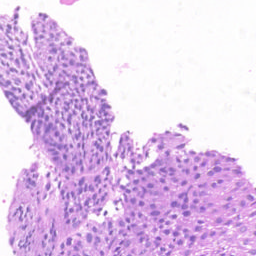

In [7]:
path = '/Volumes/AllShare/allimages/Imageset1_256/imageVal/img1015img_patch41.tif'
image = np.asarray(Image.open(path))
X_batch = image[np.newaxis, :,:,:]/255.
X_batch.shape
Image.open(path)

MASK

el promedio de la mascara es: 0.72235107421875
minimo: 0 maximo: 1


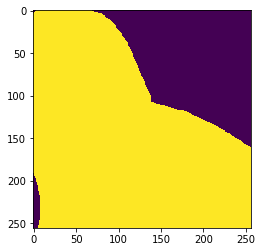

In [22]:
path = '/Volumes/AllShare/allimages/Imageset1_256/labelVal/img1015msk_patch41.tif'
mask_patch = Image.open(path)
mask_patch_np = np.asarray(mask_patch)
print('el promedio de la mascara es: {}'.format( mask_patch_np.mean()))
print('minimo: {} maximo: {}'.format(np.asarray(Image.open(path)).min(), np.asarray(Image.open(path)).max() ))

plt.imshow(mask_patch_np)

Prediccion

In [13]:
pred = unet_l9.predict(X_batch)

In [14]:
print('promedio de la prediccion {}'.format(pred.mean()))

promedio de la prediccion 0.4315459132194519


In [16]:
pred.min()

3.5481366e-22

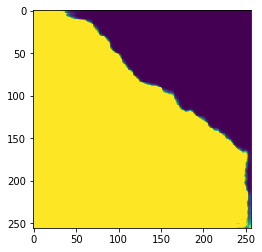

In [67]:
ypred = unet_l9.predict(X_batch)
plt.imshow(ypred[0,:,:,0])
plt.show()

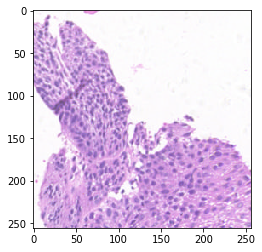

In [81]:
plt.imshow(X_batch[0,:,:])

Calculation of the dice

In [140]:
def adjustData(mask, boundary):
    mask[mask > boundary] = 1
    mask[mask <= boundary] = 0
    return mask

In [69]:
ypred_int = adjustData(ypred, 0.5).astype(np.int64)
#ypred.shape, ypred_int[0,:,:,0].shape, mask_patch_np.shape

dice_coef_np(y_pred = ypred_int[0,:,:,0], y_true = mask_patch_np)

0.9647491995731057

# Testing a whole image

In [21]:
path = '/Volumes/AllShare/allimages/boxedC/101_img_patch.tif'
path = '/Users/gsidoni/Documents/GitHub/ACDC/Data/101_img_patch.tif'

image = np.asarray(Image.open(path))
X_batch = image[np.newaxis, :,:,:]/255.
X_batch.shape

(1, 14450, 15584, 3)

In [8]:
#no correr
#pred = unet_l9.predict(X_batch)

In [ ]:
# moving waights to a new model

In [13]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import callbacks
from keras import backend as K
import keras

def unet_nonesize(pretrained_weights = None, input_size = (None,None,3)):
    
    inputs = Input(input_size)
    
    # Implementar un U-Net que tenga:
    # - Relu como función de activación
    # - 4 niveles de MaxPooling de 2x2
    # - Que utilice 'he' como método de incialización de pesos: kernel_initializer = 'he_normal'
    
    
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    #por que cambia el kernel de 2 a 3
    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    out = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(input = inputs, output = out )

    # Compilar el modelo usando Adam como algoritmo de optimización, con learning rate = 1e-5
    model.compile(optimizer = Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    
    print(model.summary())

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    print("Model created")
    return model

In [11]:
model = unet_nonesize()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 3 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/Users/gsidoni/anaconda3/envs/shipping-datascience-promesa/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [2]:
# predic on test images

In [16]:
model.set_weights(unet_l9.get_weights()) 

In [ ]:
#pred = model.predict(X_batch)

In [258]:
IMAGE_SIZE = 256


def predict_peaces(image, size, model, plot=False):
    fil = int(np.ceil(image.shape[1] / IMAGE_SIZE))
    col = int(np.ceil(image.shape[2] / IMAGE_SIZE))
    pedazo = []
    if plot:
        _, ax = plt.subplots(fil, col, figsize=[20,20])
        
    for i in range(0, col):
        col_init = i * IMAGE_SIZE 

        if (i+1) * IMAGE_SIZE <= image.shape[2]:
            col_end = (i+1) * IMAGE_SIZE 
        else:
            col_end = image.shape[2]

        #para cada fila o tira
        tira = []
        for j in range(0, fil):
            
            fil_init = j * IMAGE_SIZE            
            
            if  (j+1) * IMAGE_SIZE < image.shape[1]:
                fil_end = (j+1) * IMAGE_SIZE 
            else:
                fil_end = image.shape[1]
                
            section = image[:, fil_init:fil_end, col_init:col_end, :]
            
            if section.shape[1] < IMAGE_SIZE:
                how_match = IMAGE_SIZE - section.shape[1]
                section = np.pad(section, ((0,0),(0,how_match),(0,0),(0,0)), mode='constant', constant_values=0)

            if section.shape[2] < IMAGE_SIZE:
                how_match = IMAGE_SIZE - section.shape[2]
                section = np.pad(section, ((0,0),(0,0),(0,how_match),(0,0)), mode='constant', constant_values=0)
                
            section = model.predict(section)
            
            if plot:
                ax[j,i].imshow(Image.fromarray(section))

            #si la tira esta vacia
            if len(tira) == 0:
                tira = section
            else:
                tira = np.append(tira, section, axis=1)
                
        #cuando la tira esta completa anexo la tira al total
        if len(pedazo) == 0:
            pedazo = tira
        else:
            pedazo = np.append(pedazo, tira, axis=2)
        
    if plot:
        plt.show()
        
    return pedazo

In [188]:
def adjustData(image, boundary):
    mask = image.copy()
    mask[mask > boundary] = 1
    mask[mask <= boundary] = 0
    return mask

In [199]:
pred = predict_peaces(X_batch, IMAGE_SIZE, unet_l9)

KeyboardInterrupt: 

In [198]:
pred.max()

0.6153799

In [155]:
pred_bk = pred.copy()

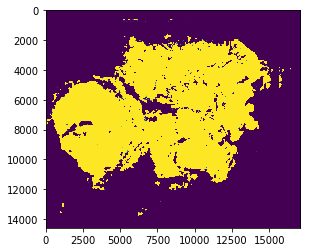

In [156]:
plt.imshow(pred[0,:,:,0])

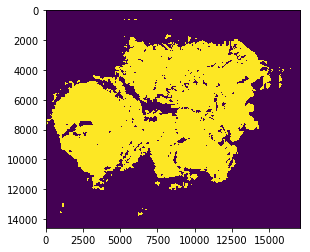

In [197]:
pred_adj = adjustData(pred[0,:,:,0], 0.611)
plt.imshow(pred_adj)
plt.show()

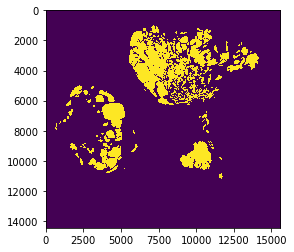

In [138]:
path = '/Users/gsidoni/Documents/GitHub/ACDC/Data/101_msk_patch.tif'

mask = np.asarray(Image.open(path))
plt.imshow(mask)

# Prediccion todo el test

In [260]:
import glob
from PIL import Image

TEST_DATA_DIR = '../Data/level2/'
IMAGE_SIZE = 256

def adjustData(image, boundary):
    mask = image.copy()
    mask[mask > boundary] = 1
    mask[mask <= boundary] = 0
    return mask



for path in glob.glob(TEST_DATA_DIR + '*.tif'):
    print(path)
    file_name = path.split('/')[-1]
    image = np.asarray(Image.open(path))
    filas = image.shape[0]
    columnas = image.shape[1]
    
    X_batch = image[np.newaxis, :,:,:]/255.
    mask_pred = predict_peaces(X_batch, IMAGE_SIZE, unet_l9)
    
    mask_pred = mask_pred[0, :filas, :columnas, 0]
    mask_pred = adjustData(mask_pred, 0.5)
    
    mask_pred = Image.fromarray(mask_pred.astype(np.int32))
    mask_pred.save('../Data/level2_pred/' + file_name)
    mask_pred.close()

../Data/level2/38_img_l2.tif
../Data/level2/24_img_l2.tif
../Data/level2/13_img_l2.tif
../Data/level2/46_img_l2.tif
../Data/level2/35_img_l2.tif
../Data/level2/29_img_l2.tif
../Data/level2/30_img_l2.tif
../Data/level2/8_img_l2.tif
../Data/level2/5_img_l2.tif
../Data/level2/16_img_l2.tif
../Data/level2/21_img_l2.tif
../Data/level2/43_img_l2.tif
../Data/level2/11_img_l2.tif
../Data/level2/26_img_l2.tif
../Data/level2/44_img_l2.tif
../Data/level2/2_img_l2.tif
../Data/level2/49_img_l2.tif
../Data/level2/37_img_l2.tif
../Data/level2/19_img_l2.tif
../Data/level2/50_img_l2.tif
../Data/level2/32_img_l2.tif
../Data/level2/23_img_l2.tif
../Data/level2/14_img_l2.tif
../Data/level2/41_img_l2.tif
../Data/level2/7_img_l2.tif
../Data/level2/9_img_l2.tif
../Data/level2/31_img_l2.tif
../Data/level2/4_img_l2.tif
../Data/level2/17_img_l2.tif
../Data/level2/20_img_l2.tif
../Data/level2/42_img_l2.tif
../Data/level2/1_img_l2.tif
../Data/level2/39_img_l2.tif
../Data/level2/25_img_l2.tif
../Data/level2/12_img

# Resize Images

In [79]:
TEST_DATA_DIR = '../Data/leveldos_pred/1_img_l2.tif'
image = Image.open(TEST_DATA_DIR)
size = image.size
size4 = np.array(image.size) * np.array([4.000094840667678, 4.000564227948091])
size4 = size4.astype(int)
print(size, size4)
#image4 = image.resize(size=size4)

(10544, 5317) [46815 21271]


In [69]:
42177/10544, 21271/5317

(4.000094840667678, 4.000564227948091)

In [124]:
import glob
from PIL import Image

TEST_DATA_DIR = '../Data/leveldos_pred/'
for path in glob.glob(TEST_DATA_DIR + '*.tif'):
    print(path)
    file_name = path.split('/')[-1]
    file_name = re.search('([0-9]+)', file_name).group(0)
    image = Image.open(path)
    size = image.size
    size4 = np.array(image.size) * np.array([4.000100300902708, 4.000564227948091])
    size4 = size4.astype(int)
    image_bool = Image.fromarray(np.asarray(image.convert("1")))
    image4_bool = image_bool.resize(size=size4)    
    image4_bool.save('../Data/levelcero_pred/' + file_name + '_mask.tiff', compression='tiff_lzw')
    image4.close()
    image4_bool.close()

../Data/leveldos_pred/38_img_l2.tif
../Data/leveldos_pred/24_img_l2.tif
../Data/leveldos_pred/13_img_l2.tif
../Data/leveldos_pred/46_img_l2.tif
../Data/leveldos_pred/35_img_l2.tif
../Data/leveldos_pred/29_img_l2.tif
../Data/leveldos_pred/30_img_l2.tif
../Data/leveldos_pred/8_img_l2.tif
../Data/leveldos_pred/5_img_l2.tif
../Data/leveldos_pred/16_img_l2.tif
../Data/leveldos_pred/21_img_l2.tif
../Data/leveldos_pred/43_img_l2.tif
../Data/leveldos_pred/11_img_l2.tif
../Data/leveldos_pred/26_img_l2.tif
../Data/leveldos_pred/44_img_l2.tif
../Data/leveldos_pred/2_img_l2.tif
../Data/leveldos_pred/49_img_l2.tif
../Data/leveldos_pred/37_img_l2.tif
../Data/leveldos_pred/19_img_l2.tif
../Data/leveldos_pred/50_img_l2.tif
../Data/leveldos_pred/32_img_l2.tif
../Data/leveldos_pred/23_img_l2.tif
../Data/leveldos_pred/14_img_l2.tif
../Data/leveldos_pred/41_img_l2.tif
../Data/leveldos_pred/7_img_l2.tif
../Data/leveldos_pred/9_img_l2.tif
../Data/leveldos_pred/31_img_l2.tif
../Data/leveldos_pred/4_img_l2.ti

In [125]:
path = '../Data/leveldos_pred/3_img_l2.tif'

image = Image.open(path)
size4 = np.array(image.size) * np.array([4.000100300902708, 4.000564227948091])
size4 = size4.astype(int)
size4, image.size



(array([62805, 67101]), (15701, 16773))

In [120]:
39881 / 9970

4.000100300902708

In [ ]:
image 1 = (21271, 42177)
image 2 = (14842, 39881)

(67095, 62805)